In [33]:
# This file we create dummy data for the three factor model and generate stocks data from it.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
# Generating the three factor data

# Number of observations
num_obs = 5000
num_factors = 3
num_trading_days = 365
start_date = pd.to_datetime('2000-01-01')

# Factor premiums (yearly decimal points)
rf = 0.01
mkt_rf = 0.05
smb = 0.01
hml = 0.02
random_shocks = 0.2

# GERENATE THE FACTOR RETURNS --------------------------------------------------------------------------------#
daily_factor_premiums = [mkt_rf / num_trading_days, smb / num_trading_days, hml / num_trading_days]
# Create some zero mean normal random shocks
shocks = np.random.normal(0, random_shocks / num_trading_days, (num_obs, num_factors + 1))

# Creating the factor returns
shocks[:, 0] = (shocks[:, 0] + daily_factor_premiums[0]) * 100
shocks[:, 1] = (shocks[:, 1] + daily_factor_premiums[1]) * 100
shocks[:, 2] = (shocks[:, 2] + daily_factor_premiums[2]) * 100
shocks[:, 3] = rf / num_trading_days * 100
# ------------------------------------------------------------------------------------------------------------#

# Make the returns a df
factor_returns = pd.DataFrame(shocks, columns=['Mkt-RF', 'SMB', 'HML', 'RF'])
# Add a date column
factor_returns['date'] = pd.date_range(start_date, periods=num_obs)

display(factor_returns.head())


,Mkt-RF,SMB,HML,RF,date
0,-0.014091,0.057857,0.082116,0.00274,2000-01-01
1,-0.068593,0.061917,-0.022841,0.00274,2000-01-02
2,0.082897,0.028635,0.034392,0.00274,2000-01-03
3,0.062898,0.100806,0.042110,0.00274,2000-01-04
4,-0.012671,-0.041757,0.075210,0.00274,2000-01-05


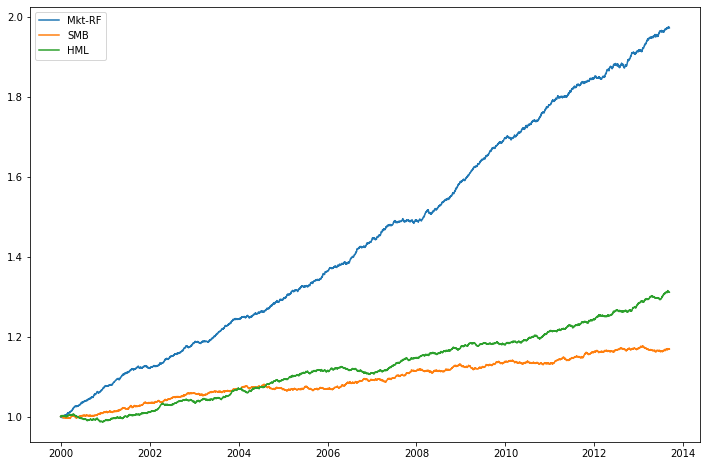

In [35]:
# Plot cumulative returns for Mkt-RF, SMB, HML
mkt_rf_cumulative_returns = (1 + factor_returns['Mkt-RF']/ 100).cumprod()
smb_cumulative_returns = (1 + factor_returns['SMB'] / 100).cumprod()
hml_cumulative_returns = (1 + factor_returns['HML'] / 100).cumprod()
dates = factor_returns['date']
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(dates, mkt_rf_cumulative_returns, label='Mkt-RF')
plt.plot(dates, smb_cumulative_returns, label='SMB')
plt.plot(dates, hml_cumulative_returns, label='HML')

plt.legend()
plt.show()


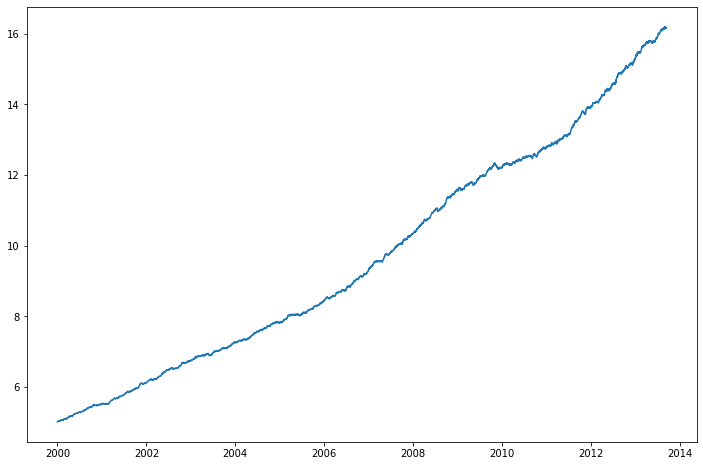

In [47]:
def generate_stock_prices(alpha, mkt_factor_loading, smb_factor_loading, hml_factor_loading, noise_dev, factor_returns, num_trading_days = 252, starting_price = 5):
    """
    Generates stock prices from the three factor model.
    :param alpha: float, the alpha of the stock
    :param mkt_factor_loading: float, the market factor loading of the stock
    :param smb_factor_loading: float, the size factor loading of the stock
    :param hml_factor_loading: float, the value factor loading of the stock
    :param noise_dev: float, the standard deviation of the noise
    :param factor_returns: pd.DataFrame, the factor returns
    :return: pd.DataFrame, the stock prices
    """
    alpha = (alpha / num_trading_days) * 100
    noise_dev = (noise_dev / num_trading_days) * 100

    # Generate the noise
    noise = np.random.normal(0, noise_dev, len(factor_returns))
    # Generate the stock returns
    stock_returns = alpha + mkt_factor_loading * factor_returns['Mkt-RF'] + smb_factor_loading * factor_returns['SMB'] + \
                    hml_factor_loading * factor_returns['HML'] + factor_returns['RF'] + noise
    # Generate the stock prices
    stock_prices = (1 + stock_returns / 100).cumprod()
    stock_prices = stock_prices * starting_price
    # Make the stock prices a df
    stock_prices = pd.DataFrame(stock_prices, columns=['price'])
    # Add a date column
    stock_prices['date'] = factor_returns['date']
    return stock_prices


# Test the function
stock_prices = generate_stock_prices(0.03, 0.5 , 0.5, 0.5, 0.3, factor_returns, num_trading_days=365)

# Plot the stock prices
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(stock_prices['date'], stock_prices['price'])
plt.show()

In [48]:
# Calculate the stock price returns
stock_returns = stock_prices['price'].pct_change().dropna()
# mean return
print('Mean return: ', (1 + stock_returns.mean()) ** 365)

Mean return:  1.0895112699104523


In [53]:
# Our final dataframe needs to have the following columns
# 'gvkey', 'iid', 'datadate', 'tic', 'cusip_x', 'ajexdi', 'cshoc',
#      'cshtrd', 'prccd', 'prchd', 'prcld', 'prcod', 'prcstd', 'trfd', 'exchg',
#     'fic', 'loc', 'sic', 'date', 'first_time_below_thresh', 'cusip_brief',
#     'cusip_y', 'fdate', 'shares', 'instituional_ownership_perc'

# Num stocks
num_stocks = 3000
num_obs = 5000
start_date = pd.to_datetime('2000-01-01')

monthly_stock_data = pd.DataFrame()

for i in range(num_stocks):
    starting_price = 4.9
    alpha = 0
    institutional_ownership_perc = np.random.uniform(0, 1)
    if(institutional_ownership_perc < 0.2):
        mkt_factor_loading = 1
        smb_factor_loading = 1
        hml_factor_loading = 1
    elif(institutional_ownership_perc < 0.4):
        mkt_factor_loading = 1.2
        smb_factor_loading = 1.2
        hml_factor_loading = 1.2
    elif(institutional_ownership_perc < 0.6):
        mkt_factor_loading = 1.5
        smb_factor_loading = 1.5
        hml_factor_loading = 1.5
    elif(institutional_ownership_perc < 0.8):
        mkt_factor_loading = 0.9
        smb_factor_loading = 0.9
        hml_factor_loading = 0.9
    else:
        mkt_factor_loading = 1
        smb_factor_loading = 1
        hml_factor_loading = 1
    
    noise_dev = np.random.uniform(0, 0.2) / 365

    stock_prices = generate_stock_prices(alpha, mkt_factor_loading, smb_factor_loading, hml_factor_loading, noise_dev, factor_returns, num_trading_days=365, starting_price=starting_price)
    # 9-digit CUSIP (random)
    cusip = ''.join([str(np.random.randint(0, 9)) for i in range(9)])
    gv_key = cusip
    iid = 1
    # 3 - letter random ticker
    ticker = ''.join([chr(np.random.randint(65, 90)) for i in range(3)])
    cusip_x = cusip
    ajexdi = 1
    cshoc = 100000
    cshtrd = 10000
    trfd = 1
    exchg = 11
    fic = 'US'
    loc = 'US'
    sic = 1000
    cusip_brief = cusip[: 8]
    cusip_y = cusip
    shares = 100000

    stock_df = pd.DataFrame({'gvkey': gv_key, 'iid': iid, 'datadate': stock_prices['date'], 'tic': ticker, 'cusip_x': cusip_x, 'ajexdi': ajexdi, 'cshoc': cshoc, 'cshtrd': cshtrd, 'prccd': stock_prices['price'], 'prchd': stock_prices['price'], 'prcld': stock_prices['price'], 'prcod': stock_prices['price'], 'prcstd': stock_prices['price'], 'trfd': trfd, 'exchg': exchg, 'fic': fic, 'loc': loc, 'sic': sic, 'date': stock_prices['date'], 'first_time_below_thresh': stock_prices['date'], 'cusip_brief': cusip_brief, 'cusip_y': cusip_y, 'fdate': stock_prices['date'], 'shares': shares, 'instituional_ownership_perc': institutional_ownership_perc}, index=range(num_obs))

    # use pd.concat 
    monthly_stock_data = pd.concat([monthly_stock_data, stock_df], axis=0)

display(monthly_stock_data)


,gvkey,iid,datadate,tic,cusip_x,ajexdi,cshoc,cshtrd,prccd,prchd,...,fic,loc,sic,date,first_time_below_thresh,cusip_brief,cusip_y,fdate,shares,instituional_ownership_perc
0,186456143,1,2000-01-01,EXH,186456143,1,100000,10000,4.906302,4.906302,...,US,US,1000,2000-01-01,2000-01-01,18645614,186456143,2000-01-01,100000,0.821195
1,186456143,1,2000-01-02,EXH,186456143,1,100000,10000,4.904999,4.904999,...,US,US,1000,2000-01-02,2000-01-02,18645614,186456143,2000-01-02,100000,0.821195
2,186456143,1,2000-01-03,EXH,186456143,1,100000,10000,4.912290,4.912290,...,US,US,1000,2000-01-03,2000-01-03,18645614,186456143,2000-01-03,100000,0.821195
3,186456143,1,2000-01-04,EXH,186456143,1,100000,10000,4.922533,4.922533,...,US,US,1000,2000-01-04,2000-01-04,18645614,186456143,2000-01-04,100000,0.821195
4,186456143,1,2000-01-05,EXH,186456143,1,100000,10000,4.923685,4.923685,...,US,US,1000,2000-01-05,2000-01-05,18645614,186456143,2000-01-05,100000,0.821195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,473475482,1,2013-09-04,XSP,473475482,1,100000,10000,15.245014,15.245014,...,US,US,1000,2013-09-04,2013-09-04,47347548,473475482,2013-09-04,100000,0.612687
4996,473475482,1,2013-09-05,XSP,473475482,1,100000,10000,15.243928,15.243928,...,US,US,1000,2013-09-05,2013-09-05,47347548,473475482,2013-09-05,100000,0.612687
4997,473475482,1,2013-09-06,XSP,473475482,1,100000,10000,15.250077,15.250077,...,US,US,1000,2013-09-06,2013-09-06,47347548,473475482,2013-09-06,100000,0.612687
4998,473475482,1,2013-09-07,XSP,473475482,1,100000,10000,15.246025,15.246025,...,US,US,1000,2013-09-07,2013-09-07,47347548,473475482,2013-09-07,100000,0.612687


In [52]:
# Calculate expected 30-day 90-day and 180-day returns for institutional ownership < 0.2
def e_return(alpha, mkt_factor_loading, smb_factor_loading, hml_factor_loading):
    ret = alpha + mkt_factor_loading * mkt_rf + smb_factor_loading * smb + hml_factor_loading * hml + rf

    print('Expected 30-day return: ', (1 + ret / 365) ** 30 - 1)
    print('Expected 90-day return: ', (1 + ret / 365) ** 90 - 1)
    print('Expected 180-day return: ', (1 + ret / 365) ** 180 - 1)

    print('\n\n')

alpha = 0

# 1
e_return(alpha, 1, 1, 1)
# 1.2
e_return(alpha, 1.2, 1.2, 1.2)
# 1.5
e_return(alpha, 1.5, 1.5, 1.5)
# 0.9
e_return(alpha, 0.9, 0.9, 0.9)
# 1
e_return(alpha, 1, 1, 1)


                

Expected 30-day return:  0.007423768980227008
Expected 90-day return:  0.022437053119620076
Expected 180-day return:  0.04537752759193281



Expected 30-day return:  0.00874911566164549
Expected 90-day return:  0.02647765777829303
Expected 180-day return:  0.053656381918010476



Expected 30-day return:  0.010740296466304367
Expected 90-day return:  0.03256819023928248
Expected 180-day return:  0.06619706749402732



Expected 30-day return:  0.006761727020726083
Expected 90-day return:  0.020422653071685337
Expected 180-day return:  0.04126239090185724



Expected 30-day return:  0.007423768980227008
Expected 90-day return:  0.022437053119620076
Expected 180-day return:  0.04537752759193281





In [54]:
# export as pickle file
monthly_stock_data.to_pickle('./../data/monthly_stock_data_simulated.pkl')
